In [203]:
import numpy as np
import torch
from torch import nn
from torchvision import models as tvmodels
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from typing import Dict, Tuple
from google.colab import files

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [226]:
def set_seed(seed):
    """
    Function for setting the seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def warmup(model, dummy_in, warmup_steps=600, **_):
    for _ in range(warmup_steps):
        model(dummy_in)


def eval_model(model, dummy_input, preprocess_fn, use_grad=False, repetitions=300, **kwargs):
    model.eval()
    dummy_input = preprocess_fn(dummy_input)
    warmup(model, dummy_input, **kwargs)

    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    records = np.zeros(repetitions)

    with torch.set_grad_enabled(use_grad):
        for rep in range(repetitions):
            start_event.record()
            model(dummy_input)
            end_event.record()
            torch.cuda.synchronize()
            records[rep] = start_event.elapsed_time(end_event)
            
    return records


def num_params(model):
    return sum(int(np.prod(p.shape)) for p in model.parameters())


def eval_one_model(model_builder, weights, accuracy, dummy_input, **kwargs):
    weights = weights.DEFAULT
    model = model_builder(weights=weights).to(device)
    times = eval_model(model, dummy_input, weights.transforms(), **kwargs)
    return {
        "name": model_builder.__name__,
        "acc@1": accuracy,
        "num_params": num_params(model),
        "inference_mean": times.mean(),
        "inference_std": times.std(),
    }


def show_models_comparison(
    df: pd.DataFrame,
    xvar: str,
    yvar: str,
    xlab: str,
    ylab: str,
    title: str,
    text_coords: Dict[str, Tuple[Tuple[float, float], str, str]] = None,
    yscale: str=None,
    fontsize=15,
    figsize=(10, 10),
    verbose=False
) -> Tuple[plt.Figure, plt.Axes]:
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(data=df, x=xvar, y=yvar, hue="name", ax=ax, legend=False, s=70)
    ax.set_xlabel(xlab, fontsize=fontsize)
    ax.set_ylabel(ylab, fontsize=fontsize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_title(title, fontsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    if yscale:
       ax.set_yscale(yscale)
    ax.grid()
    text_coords = text_coords or {}
    for i, (_, row) in enumerate(df.iterrows()):
        coords, align_h, align_v = text_coords.get(row["name"], ((0.0, 12.0), "center", "baseline"))
        if verbose:
            print(row["name"], coords, align_h, align_v)
        ax.annotate(
            row["name"],
            xy=(row[xvar], row[yvar]),
            xytext=coords,
            horizontalalignment=align_h,
            verticalalignment=align_v,
            textcoords="offset points",
            fontsize=fontsize,
        )
    return fig, ax

In [197]:
sns.set(style="ticks")

models = [
    tvmodels.vgg11,
    tvmodels.vgg11_bn,
    tvmodels.resnet18,
    tvmodels.resnet34,
    tvmodels.densenet121,
    tvmodels.mobilenet_v3_small,
]

pretrained_weights = [
    tvmodels.VGG11_Weights,
    tvmodels.VGG11_BN_Weights,
    tvmodels.ResNet18_Weights,
    tvmodels.ResNet34_Weights,
    tvmodels.DenseNet121_Weights,
    tvmodels.MobileNet_V3_Small_Weights,
]

accuracies = np.array([69.02, 70.37, 69.758, 73.314, 74.434, 67.668])
accuracies /= 100.0

In [5]:
set_seed(42)

imagenet_shape = (1, 3, 224, 224)
dummy_input = torch.rand(*imagenet_shape).to(device)
print(f"Dummy input: {dummy_input.shape} {dummy_input.dtype}")

Dummy input: torch.Size([1, 3, 224, 224]) torch.float32


In [198]:
# NOTE warmup done only for the first model so far!!!
models_times = [
    eval_one_model(model_, weights, accuracy, dummy_input, warmup_steps=warmup_steps)
    for model_, weights, accuracy, warmup_steps in zip(
        models, pretrained_weights, accuracies, [600] + [0] * (len(models) - 1)
    )
]

In [199]:
models_times_df = pd.DataFrame(models_times)
models_times_df

,name,acc@1,num_params,inference_mean,inference_std
0,vgg11,0.69020,132863336,6.492625,0.092458
1,vgg11_bn,0.70370,132868840,6.743275,0.184433
2,resnet18,0.69758,11689512,4.516007,0.612753
3,resnet34,0.73314,21797672,8.319322,0.818604
4,densenet121,0.74434,7978856,22.311878,1.531233
5,mobilenet_v3_small,0.67668,2542856,7.055905,0.848203


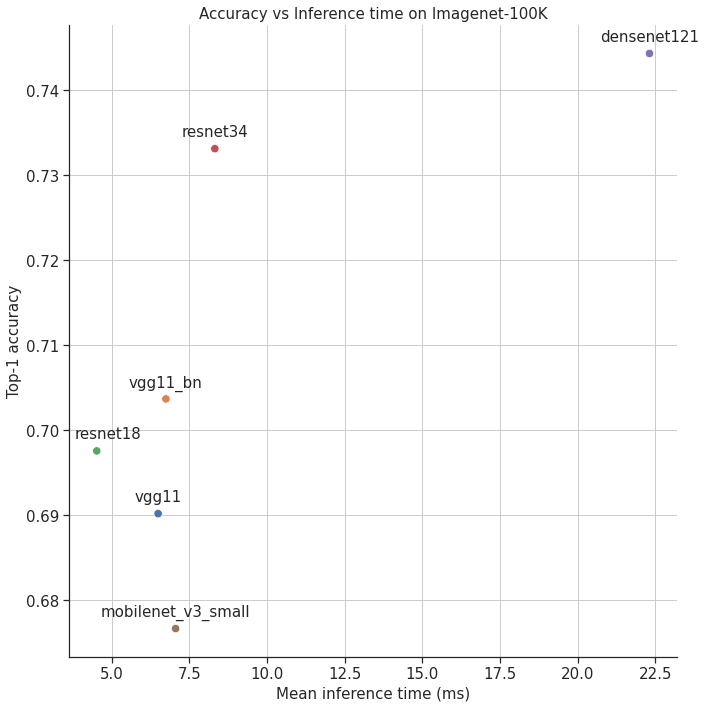

In [228]:
fig, _ = show_models_comparison(
    models_times_df,
    "inference_mean",
    "acc@1",
    "Mean inference time (ms)",
    "Top-1 accuracy",
    "Accuracy vs Inference time on Imagenet-100K",
    text_coords={"resnet18": ((11.0, 12.0), "center", "baseline")},
)
plt.tight_layout()

In [214]:
fname="accuracy_infer_speed.png"
fig.savefig(fname)
files.download(fname) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

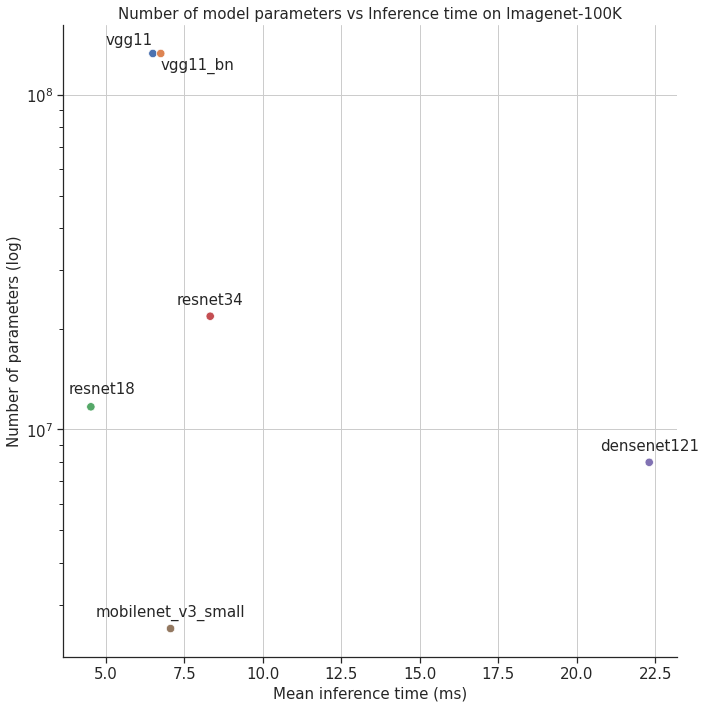

In [230]:
fig, _ = show_models_comparison(
    models_times_df,
    "inference_mean",
    "num_params",
    "Mean inference time (ms)",
    "Number of parameters (log)",
    "Number of model parameters vs Inference time on Imagenet-100K",
    text_coords={
        "resnet18": ((11.0, 13.0), "center", "baseline"),
        "vgg11": ((0.0, 9.0), "right", "baseline"),
        "vgg11_bn": ((0.0, -16.0), "left", "baseline"),
    },
    yscale="log"
)
plt.tight_layout()

In [216]:
fname="numparams_infer_speed.png"
fig.savefig(fname)
files.download(fname) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#weights = models.ResNet18_Weights.DEFAULT
#preprocess = weights.transforms()
#model = models.resnet18(weights=weights).to(device)
#times = eval_model(model, dummy_input, preprocess, warmup_steps=0)
#print(times.mean())